# Assignment: Basic Web Scrapping and more...

Fill in your name here.

In [31]:
name = 'Nikolay Bitkin'
if name == '':
    raise NotImplementedError('Put your name')

You will receive points for:
- implementing the given tasks.
- using good practices such as OOP in some cases, or decorators.
- good code structure on the last task.
- handling edge cases and exceptions.
- comprehensive unit tests (by using any of the libraries seen. I recommend `unittest`).

We will need the following libraries, but of course you can add the libraries you prefer.

In [32]:
for _ in range(2):
    try:
        from bs4 import BeautifulSoup
        import requests 
        import unittest
        import networkx as nx
    except ImportError:
        ! pip install beautifulsoup4
        ! pip install requests
        ! pip install unittest2
        ! pip install networkx
    else:
        break

In [33]:

from urllib.parse import urljoin

## Task 1

The following function receives a URL, and tries to fetch all the links on it, and returns a list with all those links.

1. Modify the function so that it returns the expected links.

2. Be sure to do unit testing to check that the behaviour of the function is the one we expect.

3. Consider edge cases (for example, what if the given URL is not a valid URL).

In [63]:
def get_all_links(url: str, validate=False):
    """
    Fetch the HTML content of 'url', parse it, and return a list of validated links.
    :param url: The webpage URL to scrape.
    :validate: specify True, if need the links to be validated by dummy load
    :return: A list of valid link URLs.
    """
    try:
        # Get the webpage
        response = requests.get(url, timeout=10)
        # Throw the exception for HTTP errors
        response.raise_for_status()  

    except requests.RequestException as e:
        print(f"Error fetching the URL '{url}': {e}")
        return []

    # Parse the page with BeautifulSoup
    soup = BeautifulSoup(response.text, "html.parser")

    # Use set to avoid any duplicates
    valid_links = list()  

    # Find all anchor tags with an href attribute
    for link_tag in soup.find_all("a", href=True):
        # Build an absolute URL (handles relative links)
        absolute_link = urljoin(url, link_tag["href"])

        # Skip mailto links and empty/local links
        if absolute_link.startswith("mailto:") or link_tag["href"].startswith("#"): #or absolute_link.endswith("#"):
            continue

        # Validate by sendng the head request
        if validate:
            try:
                head_resp = requests.head(absolute_link, allow_redirects=True, timeout=1)
                if head_resp.status_code == 200:
                    valid_links.append(absolute_link)
            except requests.RequestException:
                # skip it if got an error
                pass
        else:
            valid_links.append(absolute_link)

    return list(valid_links)


In [53]:
# 10 links without validation
l10_non_val = get_all_links('http://en.wikipedia.com')[:10]
print (l10_non_val)

['http://en.wikipedia.com/wiki/Main_Page', 'http://en.wikipedia.com/wiki/Wikipedia:Contents', 'http://en.wikipedia.com/wiki/Portal:Current_events', 'http://en.wikipedia.com/wiki/Special:Random', 'http://en.wikipedia.com/wiki/Wikipedia:About', 'http://en.wikipedia.org/wiki/Wikipedia:Contact_us', 'http://en.wikipedia.com/wiki/Help:Contents', 'http://en.wikipedia.com/wiki/Help:Introduction', 'http://en.wikipedia.com/wiki/Wikipedia:Community_portal', 'http://en.wikipedia.com/wiki/Special:RecentChanges']


In [36]:
# 10 links with validation by dummy load
l10_val = get_all_links('http://en.wikipedia.com', True)[:10]
print (l10_val)

['http://en.wikipedia.com/wiki/William_Burges', 'https://www.wikidata.org/wiki/Special:EntityPage/Q5296', 'http://en.wikipedia.com/wiki/Little_New_Year', 'https://en.wikinews.org/wiki/Main_Page', 'http://en.wikipedia.com/wiki/Palestinians_in_Israeli_custody', 'http://en.wikipedia.com/wiki/United_States_Army', 'http://en.wikipedia.com/wiki/Allium', 'http://en.wikipedia.com/wiki/Tommy_Brown_(baseball)', 'http://en.wikipedia.com/wiki/1846', 'http://en.wikipedia.com/wiki/John_Chilembwe']


In [37]:
# As we can see, validation of the links takes time, so I set the default value  for validate=False
# Check if the results are teh same for validate and non-validated calls
print(l10_non_val==l10_val)

True


## Task 2

Create a generator (`get_neighbor_pages`) that receives a URL, but instead of returning a list with all the links in that page, it should go to those links, and  **yield** their html content.

Remember to add unit tests.

In [54]:
def get_page(url: str):
    """
    Fetch the HTML content of 'url',
    :return:page content as sting
    """
    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status()  
        return response.text

    except requests.RequestException as e:
        print(f"Error fetching the URL '{url}': {e}")
        return ""


In [64]:
def get_neighbor_pages(url: str):
    """
    Go through the links in the webpage at the given URL
    and yield the html content of each of them

    :param url: A string that is the URL of the webpage
    """
    
    try:
        # Get the webpage
        page_links = get_all_links(url)

    except requests.RequestException as e:
        print(f"Error fetching the URL '{url}': {e}")
        yield ""
    #print(page_links)
    for pl in page_links:
        yield get_page(pl)
        
        

In [56]:
a= next(get_neighbor_pages('http://en.wikipedia.com'))
print (a)

['http://en.wikipedia.com/wiki/Main_Page', 'http://en.wikipedia.com/wiki/Wikipedia:Contents', 'http://en.wikipedia.com/wiki/Portal:Current_events', 'http://en.wikipedia.com/wiki/Special:Random', 'http://en.wikipedia.com/wiki/Wikipedia:About', 'http://en.wikipedia.org/wiki/Wikipedia:Contact_us', 'http://en.wikipedia.com/wiki/Help:Contents', 'http://en.wikipedia.com/wiki/Help:Introduction', 'http://en.wikipedia.com/wiki/Wikipedia:Community_portal', 'http://en.wikipedia.com/wiki/Special:RecentChanges', 'http://en.wikipedia.com/wiki/Wikipedia:File_upload_wizard', 'http://en.wikipedia.com/wiki/Main_Page', 'http://en.wikipedia.com/wiki/Special:Search', 'https://donate.wikimedia.org/?wmf_source=donate&wmf_medium=sidebar&wmf_campaign=en.wikipedia.org&uselang=en', 'http://en.wikipedia.com/w/index.php?title=Special:CreateAccount&returnto=Main+Page', 'http://en.wikipedia.com/w/index.php?title=Special:UserLogin&returnto=Main+Page', 'https://donate.wikimedia.org/?wmf_source=donate&wmf_medium=sideba

In [69]:
import unittest
from unittest.mock import patch, Mock
from bs4 import BeautifulSoup

class TestMyFuncs(unittest.TestCase):
    @patch('requests.get')
    def test_get_neighbor_pages(self, mock_get):
        mock_resp_main = Mock()
        mock_resp_main.status_code = 200
        mock_resp_main.text = """
        <html>
            <body>
                <a href="https://page.com/page1">Page 1</a>
                <a href="https://page.com/page2">Page 2</a>
                <a href="https://page.com/page3">Page 3</a>
            </body>
        </html>
        """

        mock_resp_page1 = Mock()
        mock_resp_page1.status_code = 200
        mock_resp_page1.text = "<html><body>Content of Page 1</body></html>"

        mock_resp_page2 = Mock()
        mock_resp_page2.status_code = 200
        mock_resp_page2.text = "<html><body>Content of Page 2</body></html>"

        mock_resp_page3 = Mock()
        mock_resp_page3.status_code = 200
        mock_resp_page3.text = "<html><body>Content of Page 3</body></html>"

        def side_effect(url, timeout):
            if url == "https://page.com":
                return mock_resp_main
            elif url == "https://page.com/page1":
                return mock_resp_page1
            elif url == "https://page.com/page2":
                return mock_resp_page2
            elif url == "https://page.com/page3":
                return mock_resp_page3
        mock_get.side_effect = side_effect
        
        # test get_all_links
        links = list(get_all_links("https://page.com"))

        self.assertEqual(len(links), 3)
        self.assertIn("https://page.com/page1", links[0])
        self.assertIn("https://page.com/page2", links[1])
        self.assertIn("https://page.com/page3", links[2])

        # test get_neighbor_pages
        pages = list(get_neighbor_pages("https://page.com"))
        
        self.assertEqual(len(pages), 3)
        self.assertIn(mock_resp_page1.text, pages[0])
        self.assertIn(mock_resp_page2.text, pages[1])
        self.assertIn(mock_resp_page3.text, pages[2])





In [72]:
unittest.main(argv=[''], exit=False)

.

['<html><body>Content of Page 1</body></html>', '<html><body>Content of Page 2</body></html>', '<html><body>Content of Page 3</body></html>']


.
----------------------------------------------------------------------
Ran 2 tests in 27.468s

OK


## Task 3

Create a function (`get_pages_depth()`) that receives a URL and a number `depth`, that will go through all the links the given URL, as deep as the given depth.

For example, let's say the current page `page_1` has a link to a page `page_2` and a link to a page `page_3`, and the page `page_2` has a link to a page `page_4`,  and `page_4` has a link to a page `page_5`, and `page_3` has a link to a page `page_6`, and `page_6` has a link to a page `page_7`.

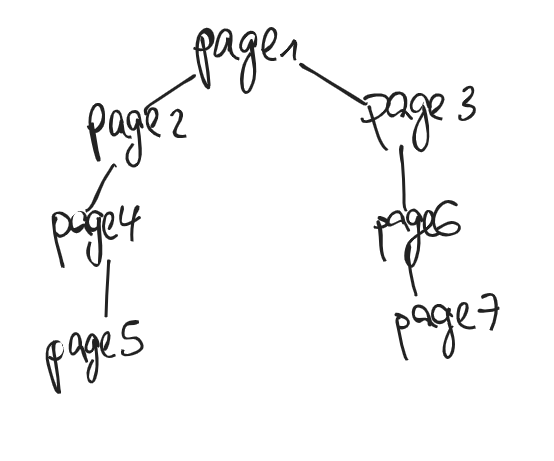

Then, if we call `get_pages_depth()` at `page_1` with `depth = 2`, then it should retrieve the pages `page_1`, `page_2`, `page_4`, `page_3` and `page_6`. We won't care about the order in which these pages are retrieved.

- Implement the function as a generator.

- Remember that a page might contain a link to a parent page, so try to take that into account.

- Consider any other edge cases that might happen, such as two pages leading to the same page. In that case, that page should only be retrieved once.

- Maybe you can add a decorator to handle such cases?

In [27]:
def get_pages_depth(url: str, depth: int):
    """
    Go as the dep as the given depth, through the links in the webpage at the given URL
    and yield the html content of each of them,  

    :param url: A string that is the URL of the webpage
    :param depth: An integer that is the depth until which the function searches
    """
    curr_depth=0
    
    # Always return teh very first page, if any 
    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status()  
        yield response.text
    except requests.RequestException as e:
        print(f"Error fetching the URL '{url}': {e}")
        yield ""

    # Visited pages  
    visited = set()
    visited.add(url)

    # Loop while we havn't reach the required depth
    # Current depth links
    curr_dp_links = set()
    curr_dp_links.add(url)
    while True: #curr_depth<depth:
        
        # yeld all pages st the current deapth
        for i_lnk in curr_dp_links:
            yield get_page(i_lnk)
            visited.add(i_lnk)

        # next level!
        curr_depth+=1
        
        # check if we're done
        if(curr_depth>depth):
            return 

        # gather all links for next depth
        new_curr_dp_links = set()
        for i_lnk in curr_dp_links:
            new_links = get_all_links(i_lnk)
            # add new links
            for n_lnk in new_links:
                if(n_lnk not in visited):
                    new_curr_dp_links.add(n_lnk)
        
        # set the new set ;)
        curr_dp_links = new_curr_dp_links

        # check if we got anything
        if(len(new_curr_dp_links)==0):
            return 


        


In [28]:
pages = get_pages_depth(depth = 2, url = 'http://en.wikipedia.org')

In [29]:
next(pages)

'<!DOCTYPE html>\n<html class="client-nojs vector-feature-language-in-header-enabled vector-feature-language-in-main-page-header-disabled vector-feature-page-tools-pinned-disabled vector-feature-toc-pinned-clientpref-1 vector-feature-main-menu-pinned-disabled vector-feature-limited-width-clientpref-1 vector-feature-limited-width-content-disabled vector-feature-custom-font-size-clientpref-1 vector-feature-appearance-pinned-clientpref-1 vector-feature-night-mode-enabled skin-theme-clientpref-day vector-sticky-header-enabled vector-toc-not-available" lang="en" dir="ltr">\n<head>\n<meta charset="UTF-8">\n<title>Wikipedia, the free encyclopedia</title>\n<script>(function(){var className="client-js vector-feature-language-in-header-enabled vector-feature-language-in-main-page-header-disabled vector-feature-page-tools-pinned-disabled vector-feature-toc-pinned-clientpref-1 vector-feature-main-menu-pinned-disabled vector-feature-limited-width-clientpref-1 vector-feature-limited-width-content-di

## Task 4

Create a class `ComputerScientist` that will contain information such as `name`, `birthdate`, `major_achievements`, `alma_mater`, etc.

- Implement the methods you consider appropriate.

- Make unit tests to make sure the methods work alright.

Write a script to go to this [list of computer scientists](https://en.wikipedia.org/wiki/List_of_computer_scientists) and fetch information about 100 random scientists from this list, and create a python `list` containing `ComputerScientist()` objects with the information retrieved from the given link.

# Task 5

Use the previously defined `ComputerScientist` class.

Add a new attribute `wikipedia_link` without modifying the definition of the original class. Consider using `setattr()`.

Write a function `fetch_scientist()` that will receive the name of a scientist, and will go to wikipedia and fetch the required scientist, and return a `ComputerScientist` object.

- Remember checking edge cases, such as the scientist not existing.

Add a decorator to cache the request, (i.e: store the answers, and if the scientist was already found before, to not execute the search again).

# Task 6**

Consider the directed graph where the nodes represent the wikipedia pages of the scientists and the edges represent whether a scientist's page contains a link to the page of another scientist.

Implement a class named `ScientistGraph`, with some attributes and methods like:
- `scientist_list : list[ComputerScientist]`: the list of all scientists
- `graph`: the graph of scientists connected to other scientists (you can use the graph object from `network`, or implement your own way of storing the graph, for e.g: with an adjacency list or an adjacency matrix).
- `add_scientist(scientist_name: str)`: method that will receive the name of the scientist, fetch the corresponding wikipedia page, create the corresponding `ComputerScientist` object, and will add the new edges involving that scientist to the graph. Consider edge cases like the name being incorrect or the scientist being already stored.
- `remove_scientist(scientist_name: str)`: method that will receive the name of a scientist, remove them from the list and removing its node and the edges involving it from the graph. Consider edge cases like the name being incorrect or the scientist not being stored.
- `plot()`: method that will visualize the graph. Show how the graph changes when adding someone new or deleting someone. Bonus: perhaps you want to implement it in a dynamic way, so each time that a scientist is removed from or added to the graph, the visualization changes.
- `rank_scientists():` method that will rank scientists. For this method you can be as creative as you wish: You can start by designing a ranking based on the number of neighbours of each scientists, or the number of times a scientist is mentioned in one of the articles, or by using the famous `PageRank (you need to google it)`, etc., or by any other methods you might like to consider.

Show the usage of these methods in a proper way.
Feel free to add more functionalities.